# Анализ поведения пользователей в мобильном приложении.

**Описание проекта:**<br>
Cтартап продаёт продукты питания. Необходимо разобраться, как ведут себя пользователи мобильного приложения. Для этого нужно изучить воронку продаж, узнать, как пользователи доходят до покупки, сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах и на каких именно? После этого нужно провести исследование результатов A/A/B-эксперимента.

Данные собраны в файле /datasets/logs_exp.csv. Каждая запись в логе — это действие пользователя, или событие.

**Описание данных:**
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import math as mth
import plotly.express as px 
from scipy import stats as st
from pandas.plotting import register_matplotlib_converters
from plotly import graph_objects as go
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

**1. Общая информация.**

In [2]:
data = pd.read_csv("/datasets/logs_exp.csv", sep = "\t")

In [3]:
data

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**2. Подготовка данных.**

Изменим названия столбцов.

In [5]:
data.rename(columns = {"EventName" : "event_name",
                       "DeviceIDHash" : "user_id",
                       "EventTimestamp" : "event_timestamp",
                       "ExpId" : "exp_id"}, inplace = True)

Изменим тип данных в столбце "event_timestamp".

In [6]:
data["event_timestamp"] = pd.to_datetime(data["event_timestamp"], unit = "s")

Проверим наличие дубликатов и пропусков.

In [7]:
data.duplicated().sum()

413

In [8]:
data.isna().sum()

event_name         0
user_id            0
event_timestamp    0
exp_id             0
dtype: int64

Дубликатов в данных менее одного процента. Их можно удалить.

In [9]:
data = data.drop_duplicates().reset_index(drop = True)

In [10]:
data.duplicated().sum()

0

In [11]:
data

,event_name,user_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248
...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.4+ MB


Название и тип данных в таблице изменениы. Дубликаты удалены. Пропусков в таблице нет.

Добавим столбец с датой и временем, а также отдельный столбец дат.

In [13]:
data["event_time"] = pd.to_datetime(data["event_timestamp"], unit = "s")
data["date"] = data["event_time"].dt.date

In [14]:
data

,event_name,user_id,event_timestamp,exp_id,event_time,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07 21:12:25,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07 21:13:59,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07 21:14:43,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07 21:14:58,2019-08-07


**Вывод:**<br>
В таблице изменены названия и регистр столбцов, проверены и удалены дубликаты, а также добавлены столбец с датой и временем и отдельный столбец дат. Пропуски в данных отсутствовали.

**3. Изучение и проверка данных.**

**3.1. Сколько всего событий в логе.**

In [15]:
print("Количество событий в логе:", data.shape[0])

Количество событий в логе: 243713


**3.2. Сколько всего пользователей в логе.**

In [16]:
print("Количество пользователей в логе:", data["user_id"].nunique())

Количество пользователей в логе: 7551


**3.3. Сколько в среднем событий приходится на пользователя.**

In [17]:
print(" Среднее количество событий на пользователя:", round(data.shape[0] / data["user_id"].nunique()))

 Среднее количество событий на пользователя: 32


Проверим по другому

In [18]:
users_events = data.groupby("user_id")["event_name"].count()

In [19]:
users_events.describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event_name, dtype: float64

Среднее количество событий на пользователя, как и количество самих пользователей совпадает с предыдущими расчётами. В данных присутствует аномально большое значение 2307.

**3.4. Максимальная и минимальная дата. Гистограмма по дате и времени. Выяснить насколько данные полные. Установить за какой в действительности период имеются данные.**

In [20]:
print("Минимальная дата:", data["date"].min())
print("Максимальная дата:", data["date"].max())

Минимальная дата: 2019-07-25
Максимальная дата: 2019-08-07


Данные охватывают две недели.

Text(0.5, 1.0, 'Гистограмма по дате и времени')

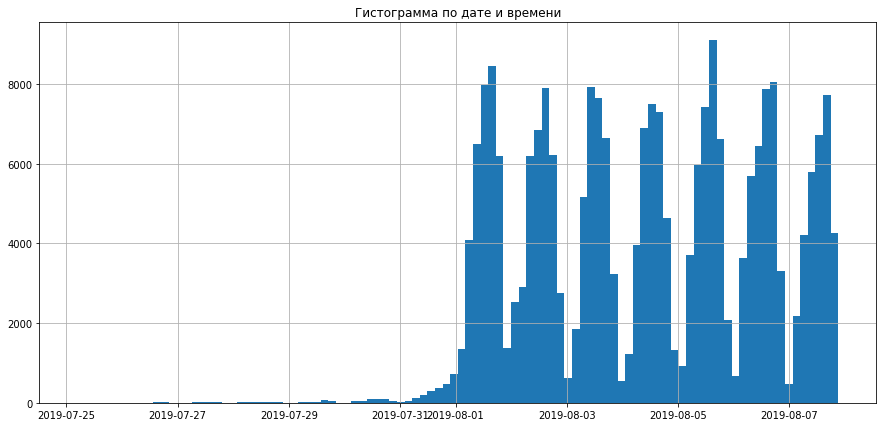

In [21]:
data["event_time"].hist(bins = 100, figsize = (15, 7))
plt.title("Гистограмма по дате и времени")

Text(0.5, 1.0, 'Гистограмма по дате и времени')

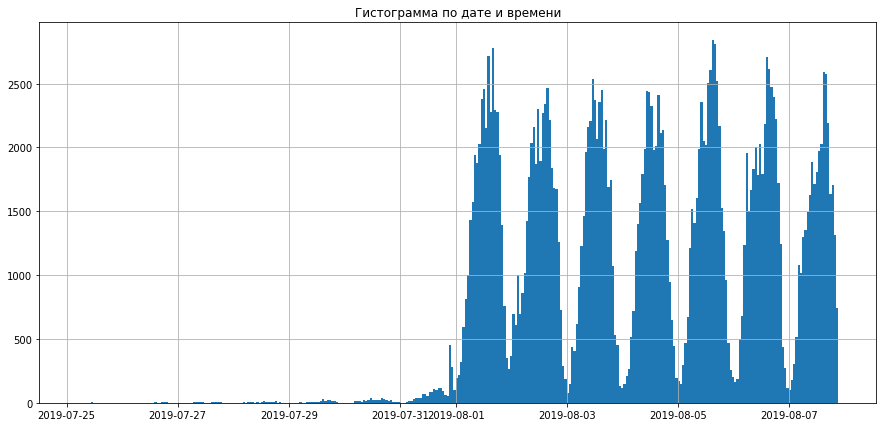

In [22]:
data["event_time"].hist(bins = 14*24, figsize = (15, 7))
plt.title("Гистограмма по дате и времени")

Судя по гистограмме, данные, в основном, собраны за первую неделю августа, при этом минимальная дата, которая стоит в таблице - 25.07.2019 г. Вполне возможно, такое расхождение обусловлено влиянием событий из прошлого. Чтобы в дальнейшем данные были более корректными, необходимо отсечь данные за июль.

In [23]:
data_filtered = data[(data["date"] >= dt.date(2019, 8, 1)) & (data["date"] <= dt.date(2019, 8, 7))]

In [24]:
data_filtered

,event_name,user_id,event_timestamp,exp_id,event_time,date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07 21:12:25,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07 21:13:59,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07 21:14:43,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07 21:14:58,2019-08-07


In [25]:
print("Минимальная дата:", data_filtered["date"].min())
print("Максимальная дата:", data_filtered["date"].max())

Минимальная дата: 2019-08-01
Максимальная дата: 2019-08-07


Text(0.5, 1.0, 'Гистограмма по дате и времени')

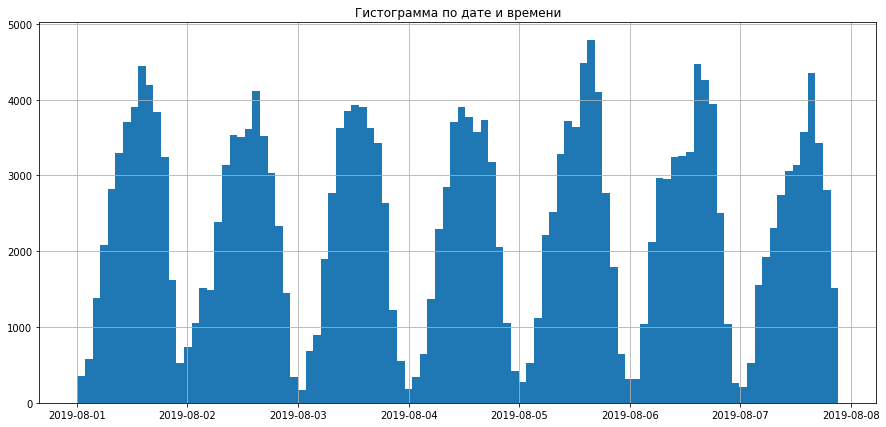

In [26]:
data_filtered["event_time"].hist(bins = 100, figsize = (15, 7))
plt.title("Гистограмма по дате и времени")

Срез сделан. Теперь данные более корректные.

**3.5. Сколько событий и пользователей потеряли, отбросив старые данные.**

In [27]:
print("Количество событий в логе до фильтрации:", data.shape[0])
print("Количество пользователей в логе до фльтрации:", data["user_id"].nunique())
print()
print("Количество событий в логе после фильтрации:", data_filtered.shape[0])
print("Количество пользователей в логе после фильтрации:", data_filtered["user_id"].nunique())

Количество событий в логе до фильтрации: 243713
Количество пользователей в логе до фльтрации: 7551

Количество событий в логе после фильтрации: 240887
Количество пользователей в логе после фильтрации: 7534


In [28]:
print("Количество потерь событий в логе после фильтрации:", data.shape[0] - data_filtered.shape[0])
print("Количество потерь пользователей в логе после фильтрации:", data["user_id"].nunique() - data_filtered["user_id"].nunique())

Количество потерь событий в логе после фильтрации: 2826
Количество потерь пользователей в логе после фильтрации: 17


In [29]:
print("Процент потерь событий в логе после фильтрации:", round((data.shape[0] - data_filtered.shape[0]) / data.shape[0] * 100, 2), "%")
print("Процент потерь пользователей в логе после фильтрации:", round((data["user_id"].nunique() - data_filtered["user_id"].nunique()) / data["user_id"].nunique() * 100, 2), "%")

Процент потерь событий в логе после фильтрации: 1.16 %
Процент потерь пользователей в логе после фильтрации: 0.23 %


Потери несущественные.

**3.6. Проверка наличия пользователей из всех трёх экспериментальных групп.**

In [30]:
data_filtered.groupby("exp_id").agg({"user_id": "nunique"})

,user_id
exp_id,
246,2484
247,2513
248,2537


В таблице присутствуют данные пользователей из всех трёх групп. Разница в размере между группами незначительная.

**Вывод:**<br>
Изначально в таблице были данные о событиях за две недели - последнюю неделю июля и первую неделю августа. Однако, после проверки, выяснилось, что фактически присутствуют данные только за август, что скорее всего, было обусловлено влиянием событий из прошлого. Для предотвращения искажений в дальнейшем, был проведён срез данных и отсечена информация за июль. Количество потерянных данных при этом было минимальным. Также было проверено наличие в таблице информации о пользователях из всех трёх групп. В настоящее время данные в целом корректны, группы, примерно, равны.

**4. Изучение воронки событий.**

**4.1. Типы событий и частота их появления.**

In [31]:
data_filtered.pivot_table(index = "event_name", values = "user_id", aggfunc = "count").sort_values(by = "user_id", ascending = False).reset_index()

,event_name,user_id
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Для наглядности построим диаграмму.

<AxesSubplot:title={'center':'Типы событий и частота их появления'}, ylabel='user_id'>

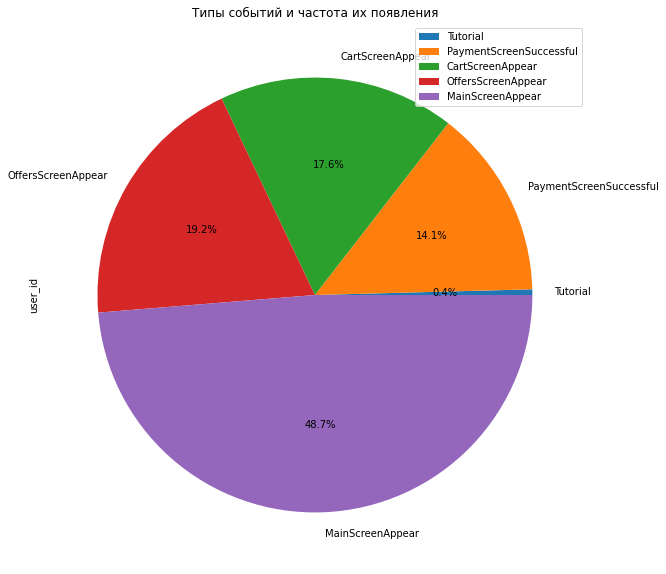

In [32]:
data_filtered.pivot_table(index = "event_name", values = "user_id", aggfunc = "count").sort_values(by = "user_id").plot(y = "user_id", kind = "pie", figsize = (12, 10), autopct = "%1.1f%%", title = "Типы событий и частота их появления")

Чаще всего просходило событие "MainScreenAppear" ("Появление главного экрана"). Именно его совершило самое большое количество пользователей. Далее частота появления событий начинает уменьшаться пропорционально уменьшению количества пользователей. 

**4.2. Количество уникальных пользователей, которые совершали каждое из этих событий. Доля пользователей, которые хоть раз совершали каждое событие.**

In [33]:
percent_unique_users = data_filtered.groupby("event_name").agg({"user_id": "nunique"}).rename(columns = {"user_id": "unique_users"}).sort_values(by = "unique_users", ascending = False).reset_index()
percent_unique_users

,event_name,unique_users
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [34]:
percent_unique_users["percent_conversion_all"] =  round(
    percent_unique_users["unique_users"] / data_filtered["user_id"].nunique(), 2
)
percent_unique_users

,event_name,unique_users,percent_conversion_all
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


<AxesSubplot:title={'center':'Количество уникальных пользователей для каждого события'}, ylabel='user_id'>

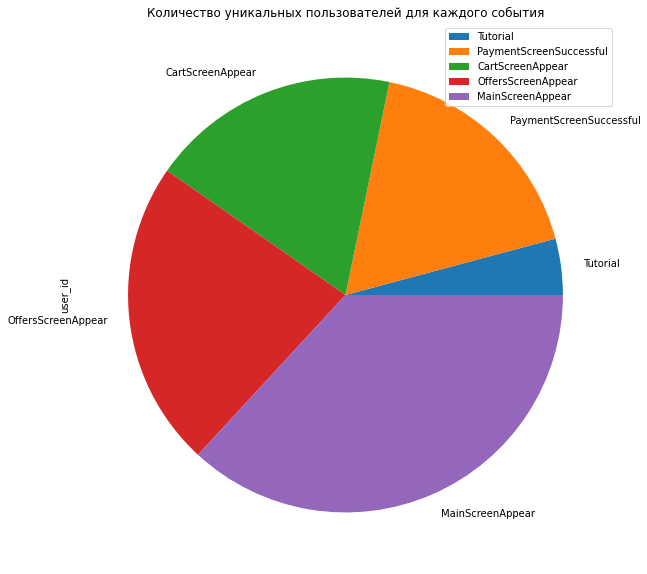

In [35]:
data_filtered.groupby("event_name").agg({"user_id": "nunique"}).sort_values(by = "user_id").plot(y = "user_id", kind = "pie", figsize = (12, 10), title = "Количество уникальных пользователей для каждого события")

В конверсии присутствуют два заметных провала: между 1 и 2 шагом, а также между 4 и 5. Необычно, что есть такое значительное снижение между появлением Экрана успешной оплаты (4 шаг) и появлением Экрана с обучением (5 шаг). Это может объясняться тем, что инструкции появляются вначале и их часто можно пропустить, а также тем, что после покупки пользователи, через некоторое время, снова переходят к ним, при этом некоторые пользователи закрывают приложение сразу после подтверждения успешной оплаты. Остальные показатели конверсии хорошие, при переходе с одного этапа на другой сохраняется высокий процент пользователей.

При этом также следует отметить, что если брать только уникальных пользователей, то доля пользователей от общего числа на первом этапе уменьшилась, а на остальных увеличилась.

**4.3. Порядок событий. Все ли они выстраиваются в последовательную цепочку.**

Посчитаем конверсию уникальных пользователей для каждого этапа.

In [36]:
percent_unique_users["step_conversion_unique"] = round(percent_unique_users["unique_users"] / percent_unique_users["unique_users"].shift(), 2)
percent_unique_users

,event_name,unique_users,percent_conversion_all,step_conversion_unique
0,MainScreenAppear,7419,0.98,NaN
1,OffersScreenAppear,4593,0.61,0.62
2,CartScreenAppear,3734,0.50,0.81
3,PaymentScreenSuccessful,3539,0.47,0.95
4,Tutorial,840,0.11,0.24


Конверсия, как и должна, растёт от этапа к этапу. Исключение составляет этап "Tutorial" у которого она резко падает. Связано это с тем, что он, как правило, появляется вначале и не является обязательным, его можно пропустить. Пользователей, после оплаты, снова перемещают на этот этап, но не все туда переходят, некоторые просто закрывают приложение, поэтому и конверсия тоже резко падает. В общих расчётах его можно не учитывать.<br>
Также возможен вариант, что часть пользователей сразу попадает на этап "OffersScreenAppear" (Страница с товарами, каталог), например, через рекламу.

В большинстве случаев этапы выстроены так (без учёта "Tutorial"):
1. MainScreenAppear;
2. OffersScreenAppear;
3. CartScreenAppear;
4. PaymentScreenSuccessful.

**4.4. Доля пользователей, которая переходит на следующий шаг воронки (от числа пользователей на предыдущем). На каком шаге теряете больше всего пользователей? Какая доля пользователей доходит от первого события до оплаты?**

На предыдущем этапе уже был сделан похожий подсчёт. Сейчас сделаем расчёт без учёта "Tutorial".

In [37]:
funnel = (
    data_filtered
    .groupby("event_name")["user_id"].nunique()
    .sort_values(ascending = False)
    .reset_index()
)
funnel = funnel.query('event_name != "Tutorial"')
funnel["share_users"] = round(funnel["user_id"] / funnel["user_id"].shift(periods = 1, fill_value = 1 * funnel["user_id"][0]), 2)
funnel

,event_name,user_id,share_users
0,MainScreenAppear,7419,1.00
1,OffersScreenAppear,4593,0.62
2,CartScreenAppear,3734,0.81
3,PaymentScreenSuccessful,3539,0.95


In [38]:
print("Процент пользователей, прошедших все этапы:", round((funnel.iloc[3,1] / funnel.iloc[0,1]) * 100, 2), "%")

Процент пользователей, прошедших все этапы: 47.7 %


**Вывод:**<br>
1. Самым частым событием ожидаемо является "MainScreenAppear" ("Появление главного экрана"), но также именно после него теряется самое большое число пользователей - около 40%.
2. В большинстве случаев этапы идут последовательно, один за другим, и конверсия от этапа к этапу растёт. Исключение составляет этап "Tutorial" ("Инструкции"), который не имеет прямого отношения к продажам и не учитывался в расчётах.
3. Конверсия показывает хорошие результаты. Около 48% процентов пользователей проходят все этапы и доходят до покупки. Нужно также заметить, что практически все пользователи, оформившие заказ, оплачивают его.

**5. Изучение результатов эксперимента.**

**5.1. Количество пользователей в каждой экспериментальной группе.**

In [39]:
users_quantity = (
    data_filtered
    .groupby("exp_id")
    .agg({"user_id": "nunique"})
    .rename(columns = {"exp_id": "group", "user_id": "users_quantity"})
)

users_quantity

,users_quantity
exp_id,
246,2484
247,2513
248,2537


В целом группы, примерно, равны по размеру. Разница незначительна.

**5.2. Проверка наличия разницы по статистическим критериям между выборками 246 и 247 (две контрольные группы).**

Соберём данные по группам в отдельную таблицу.

In [40]:
events = data_filtered.pivot_table(index = "event_name", columns = "exp_id", values = "user_id", aggfunc = "nunique")
events

exp_id,246,247,248
event_name,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


Посчитаем конверсию двух контрольных групп и сколько пользователей в итоге доходят до оплаты товара.

Сформулируем гипотезы:<br>
Нулевая гипотеза: различий между выборками контрольных групп нет.<br>
Альтернативная гипотеза: различие между выброками контрольных групп есть.<br>
Уровень значимости: 0,05.

In [41]:
def hypothesis(successes1, successes2, trials1, trials2):
    p1 = successes1 / trials1
    p2 = successes2 / trials2
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials1 + 1 / trials2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    return p_value

alpha = 0.05 / 16
for event in ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']:
    if hypothesis(events.loc[event, 246], events.loc[event, 247],
                        users_quantity.loc[246].values[0], users_quantity.loc[247].values[0]) < alpha:
        trig = "значимо"
        print("Отвергаем нулевую гипотезу: между выборками контрольных групп есть разница")
    else:
        trig = "незначимо"
        print("Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы")
    print(f"Отличие между группами 246 и 247 по событию {event} статистически {trig}, p_value =",
         hypothesis(events.loc[event, 246], events.loc[event, 247],
                        users_quantity.loc[246].values[0], users_quantity.loc[247].values[0]))

Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы
Отличие между группами 246 и 247 по событию MainScreenAppear статистически незначимо, p_value = 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы
Отличие между группами 246 и 247 по событию OffersScreenAppear статистически незначимо, p_value = 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы
Отличие между группами 246 и 247 по событию CartScreenAppear статистически незначимо, p_value = 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы
Отличие между группами 246 и 247 по событию PaymentScreenSuccessful статистически незначимо, p_value = 0.11456679313141849


Между контрольными группами нет статистически значимой разницы.

**5.3. Выберем самое популярное событие. Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие. Проверим, будет ли отличие между группами статистически достоверным. Сделаем то же самое для всех других событий. Можно ли сказать, что разбиение на группы работает корректно.**

Как следует из предыдущих расчётов, самое популярным событием является "MainScreenAppear" - появление главного экрана.

In [42]:
events_filtered = data_filtered.query('event_name != "Tutorial"')
events_filtered["event_name"].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Name: event_name, dtype: int64

In [43]:
print('Число пользователей совершивших событие "MainScreenAppear": ', \
      data_filtered.groupby("exp_id")["user_id"].nunique().sum())

Число пользователей совершивших событие "MainScreenAppear":  7534


Посчитаем, сколько пользователей совершило это событие в каждй из контрольных групп и их долю.

In [44]:
users_quantity_gr = (
    data_filtered
    .groupby("exp_id")
    .agg({"user_id": "nunique"})
    .rename(columns = {"exp_id": "group", "user_id": "users_quantity"})
)

users_quantity_gr

,users_quantity
exp_id,
246,2484
247,2513
248,2537


In [45]:
users_groups = (
    data_filtered
    .pivot_table(index = "exp_id",
                 columns = "event_name",
                 values = "user_id",
                 aggfunc = "nunique")
    .reset_index()
)

users_groups["users_quantity"] = users_quantity_gr["users_quantity"]
users_groups.rename(columns = {"CartScreenAppear" : "cart_screen_appear",
                               "MainScreenAppear" : "main_screen_appear",
                               "OffersScreenAppear" : "offers_screen_appear",
                               "PaymentScreenSuccessful" : "payment_screen_successful",
                               "Tutorial" : "tutorial",
                               "exp_id" : "group"}, inplace = True)

In [46]:
def groups (g):
    if g == 246:
        return "A1"
    elif g == 247:
        return "A2"
    elif g == 248:
        return "B"

users_groups["group"] = users_groups["group"].apply(groups)

In [47]:
users_groups

event_name,group,cart_screen_appear,main_screen_appear,offers_screen_appear,payment_screen_successful,tutorial,users_quantity
0,A1,1266,2450,1542,1200,278,NaN
1,A2,1238,2476,1520,1158,283,NaN
2,B,1230,2493,1531,1181,279,NaN


In [48]:
top_event = users_groups[["group", "main_screen_appear", "users_quantity"]].copy()
top_event["users_percent"] = round(top_event["main_screen_appear"] / top_event["users_quantity"], 2)
top_event

event_name,group,main_screen_appear,users_quantity,users_percent
0,A1,2450,NaN,NaN
1,A2,2476,NaN,NaN
2,B,2493,NaN,NaN


Практически все пользователи в каждой из групп совершили событие "MainScreenAppear".

Проверим, будет ли отличие между контрольными группами A1 и A2 статистически достоверным.

In [49]:
events_group = data_filtered
events_group.rename(columns = {"exp_id" : "group"}, inplace = True)
events_group["group"] = events_group["group"].apply(groups)
events_group[events_group["event_name"] != "Tutorial"]
events_group.head()

,event_name,user_id,event_timestamp,group,event_time,date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,A1,2019-08-01 00:07:28,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,A1,2019-08-01 00:08:00,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,A1,2019-08-01 00:08:55,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,A1,2019-08-01 00:08:58,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,A2,2019-08-01 00:08:59,2019-08-01


In [50]:
events_gr = (
    events_group
    .pivot_table(index = "event_name",
                 columns = "group",
                 values = "user_id", 
                 aggfunc = "nunique")
    .reset_index()
)
events_gr = events_gr.query('event_name != "Tutorial"')
events_gr["control_all"] = events_gr["A1"] + events_gr["A2"]
events_gr

group,event_name,A1,A2,B,control_all
0,CartScreenAppear,1266,1238,1230,2504
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
3,PaymentScreenSuccessful,1200,1158,1181,2358


In [51]:
users_quantity_gr1 = (
    data_filtered
    .groupby("group")["user_id"]
    .nunique()
)
users_quantity_gr1["control_all"] = users_quantity_gr1["A1"] + users_quantity_gr1["A2"]
users_quantity_gr1

group
A1             2484
A2             2513
B              2537
control_all    4997
Name: user_id, dtype: int64

In [52]:
def z_test(group1, group2, alpha):
    for i in events_gr.index:
        # Успехи в первой группе:
        p1 = events_gr[group1][i] / users_quantity_gr1[group1]
        # Успехи во второй группе:
        p2 = events_gr[group2][i] / users_quantity_gr1[group2]
        # Успехи в комбинированном датасете:
        p_combined = ((events_gr[group1][i] + events_gr[group2][i]) / 
                      (users_quantity_gr1[group1] + users_quantity_gr1[group2]))
        # Разница пропорций в группах:
        difference = p1 - p2
        # Стандартное отклонение стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/users_quantity_gr1[group1] + 1/users_quantity_gr1[group2]))
        # Стандартное нормальное распределение (среднее - 0, стандартное отклонение - 1)
        distr = st.norm(0, 1) 
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print("{} p-значение: {}".format(events_gr["event_name"][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между выборками контрольных групп есть разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы")
        print("")
        
z_test("A1", "A2", 0.05)

CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы



Статистически значимой разницы между группами нет.

Проверим насколько корректно пользователи разделены по группам. Проверим, нет ли пересекающихся пользователей.

In [53]:
group_a1 = data_filtered.loc[data_filtered["group"] == "A1"]["user_id"] 
group_a2 = data_filtered.loc[data_filtered["group"] == "A2"]["user_id"]
group_b = data_filtered.loc[data_filtered["group"] == "B"]["user_id"]
result_1 = list(set(group_a1) & set(group_a2)) 
result_2 = list(set(group_a1) & set(group_b))
result_3 = list(set(group_a2) & set(group_b))
print("Количество пересекающихся пользователей в группах A1 и A2: ", len(result_1))
print("Количество пересекающихся пользователей в группах A1 и B: ", len(result_2))
print("Количество пересекающихся пользователей в группах A2 и B: ", len(result_3))

Количество пересекающихся пользователей в группах A1 и A2:  0
Количество пересекающихся пользователей в группах A1 и B:  0
Количество пересекающихся пользователей в группах A2 и B:  0


Самым популярным событием является "MainScreenAppear". Практически все пользователи из контрольных групп совершили его. При этом статистически значимой разницы между контрольными группами для всех событий нет. Пересекающихся пользователей в группах нет, сами группы по размеру практически однаковы. Можно сделать вывод, что группы разбиты корректно.

**5.4. Сравнение результатов группы "B" с каждой из контрольных групп в отдельности, а также с объединённой контрольной группой по каждому событию.**

In [54]:
z_test("A1", "B", 0.05)

CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы



In [55]:
z_test("A2", "B", 0.05)

CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы



In [56]:
z_test("control_all", "B", 0.05)

CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы



Значимой резницы между группами не выявлено.

**5.5. Уровень значимости вы выбрали при проверке статистических гипотез. Сколько проверок статистических гипотез сделано.**

Всего провередно 20 тестов. Был выбран уровень значимости 0,05. Поскольку тесты были множественные, то с каждой новой проверкой растёт вероятность ошибки первого рода. Попробуем установить уровень 0,01 и перепроверить тесты.

In [57]:
z_test("A1", "A2", 0.01)

CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы



In [58]:
z_test("A1", "B", 0.01)

CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы



In [59]:
z_test("A2", "B", 0.01)

CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы



In [60]:
z_test("control_all", "B", 0.01)

CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы

PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу: между выборками контрольных групп нет разницы



При изменении уровня значимости, результаты не изменились.

**Вывод:**<br>
1. Группы в целом равны и разделены корректно.
2. Между контрольными группами ("A1" и "A2") нет статистически значимой разницы.
3. Самым популярным событием является "MainScreenAppear" ("Появление главного экрана"), практически все пользователи всех групп его прошли.
4. Между экспериментальной группой ("B") и контрольными, а также объединённой контрольной, нет статистически значимой разницы.
5. Изменение уровня значимости не повлияло на результаты тестов.

**Общий вывод:**<br>
1. Эксперимент, в целом, можно признать успешным. 
2. У конверсии хорошие показатели, около 48% процентов пользователей проходят все этапы и доходят до покупки. Практически все пользователи, оформившие заказ, оплачивают его.
3. Необходимо обратить внимание на главный экран, после него теряется около 40% пользователей.
4. Между эксперементальной группой ("B") и контрольными, а также объединённой контрольной, нет статистически значимой разницы. Изменение уровня значимости не повлияло на результаты тестов. **На основании этого можно сделать вывод, что изменение шрифта не повлияло на действия пользователей в приложении.**
5. Эксперимент можно остановить. Продолжать его, учитывая показатели в тестах, нет необходимости.